In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import os
import pc
import ecg_plot

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy import optimize
from scipy.io import loadmat
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Add
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional

In [3]:
gender, age, labels, ecg_filenames = pc.import_key_data("WFDB/")

In [4]:
ecg_filenames = np.asarray(ecg_filenames)

In [6]:
SNOMED_scored = pd.read_csv("SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored = pd.read_csv("SNOMED_mappings_unscored.csv", sep=";")
df_labels = pc.make_undefined_class(labels,SNOMED_unscored)

In [7]:
y , snomed_classes = pc.onehot_encode(df_labels)

The classes we will look at are encoded as SNOMED CT codes:
['10370003' '111975006' '164889003' '164890007' '164909002' '164917005'
 '164934002' '164947007' '251146004' '270492004' '284470004' '39732003'
 '426177001' '426783006' '427084000' '427393009' '445118002' '47665007'
 '59931005' '63593006' '698252002' '713426002' '713427006'
 'undefined class']
classes: 23


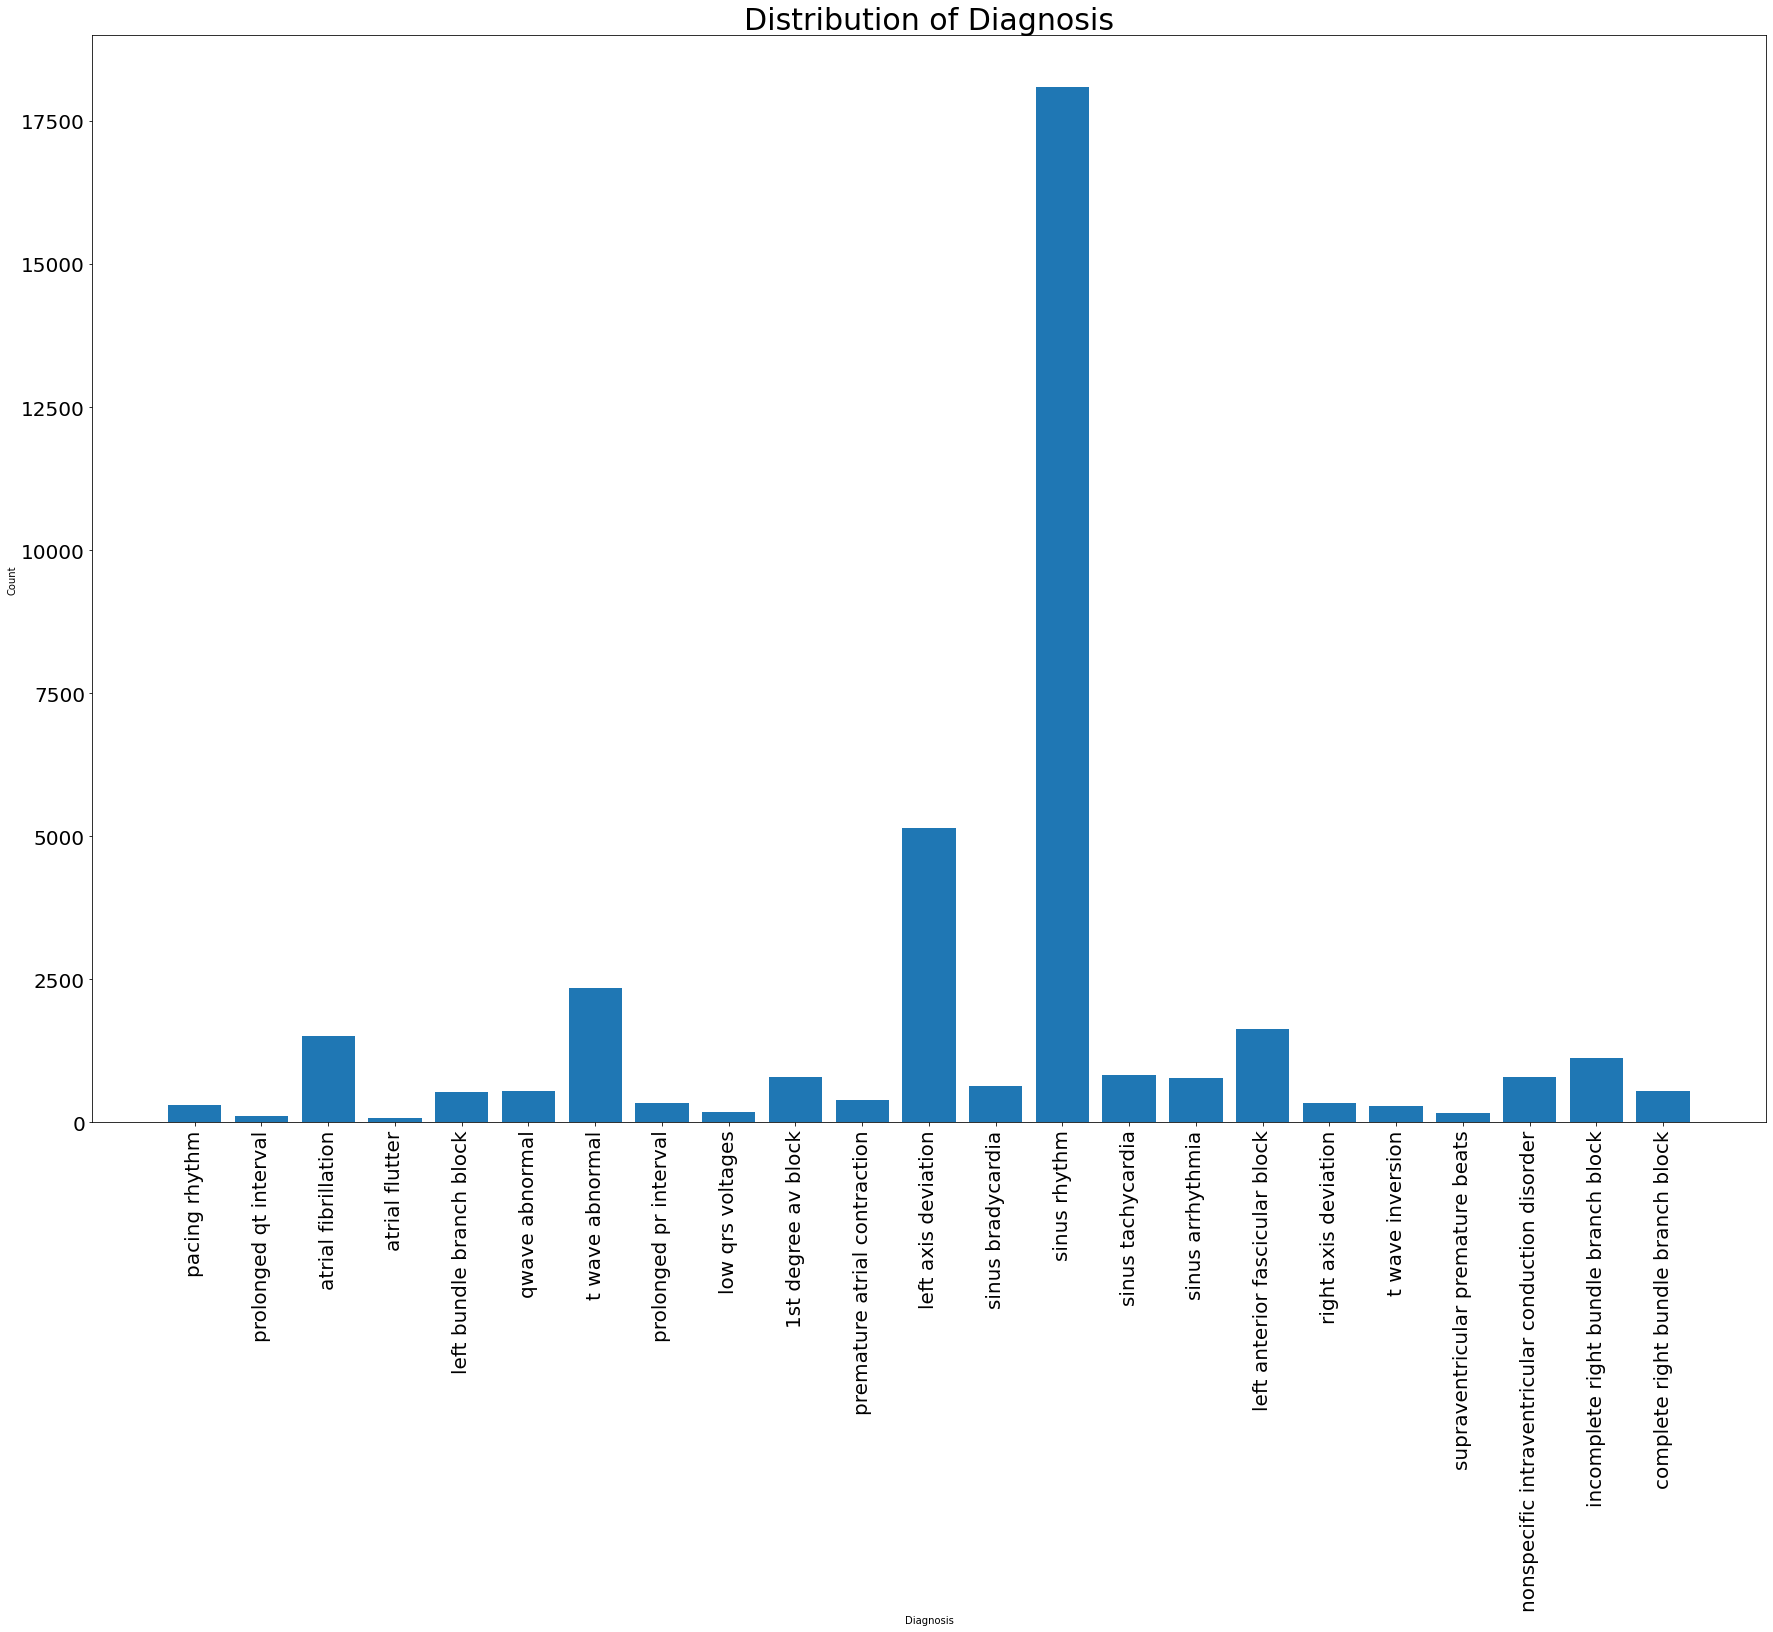

In [8]:
pc.plot_classes(snomed_classes, SNOMED_scored,y)